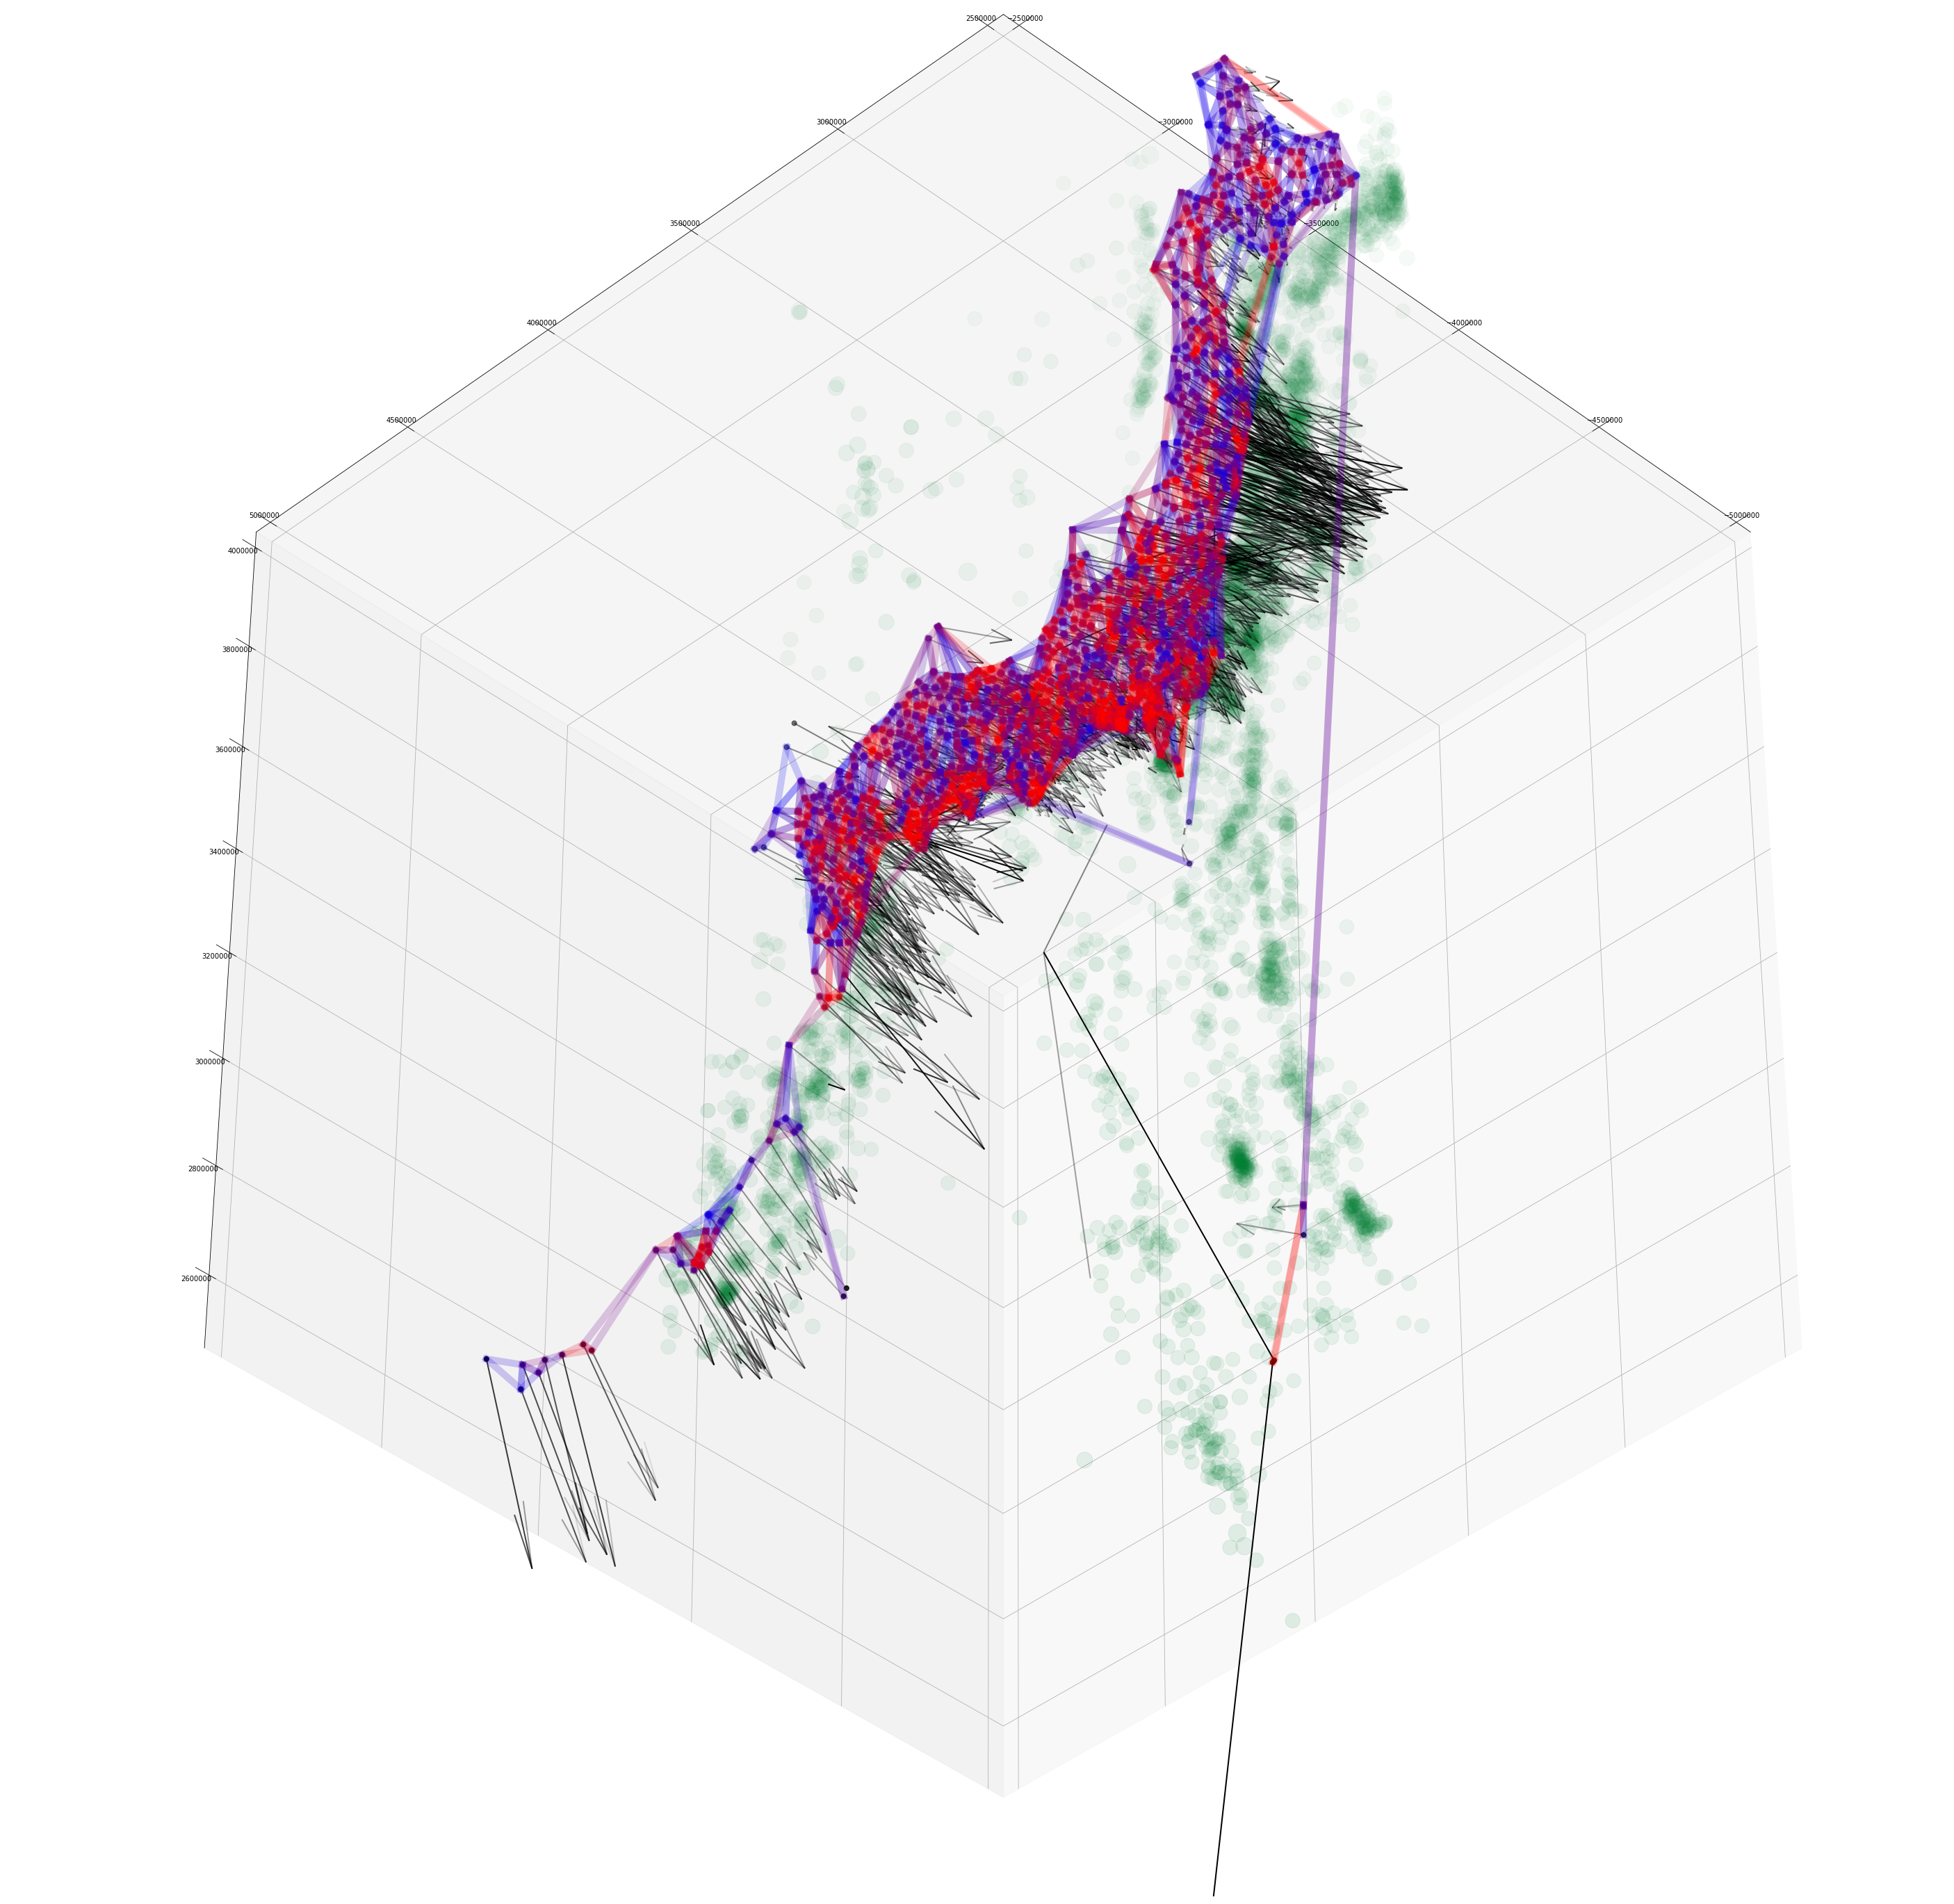

In [154]:
# jun hirabayashi jun@hirax.net
# 記事用コード

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import axes3d
from sympy.geometry import *

#%matplotlib notebook
%matplotlib inline
plt.style.use({'figure.figsize': (50, 50)})
fig = plt.figure(); ax = plt.axes( projection='3d' )
ax.set_xlim( -2500000,-5000000 )
ax.set_ylim( 2500000, 5000000 )
ax.set_zlim( 2500000, 4000000 )

def plot_tris( ax, points, tri ):
    for tr in tri.simplices: 
        pts = points[ tr, : ]         #pts = [ points[ p ] for p in tr ]
        ax.plot3D( pts[ [0, 1], 0], pts[ [0, 1], 1 ], pts[ [0, 1], 2 ], color='g', lw='0.05' )
        ax.plot3D( pts[ [0, 2], 0], pts[ [0, 2], 1 ], pts[ [0, 2], 2 ], color='g', lw='0.05' )
        ax.plot3D( pts[ [1, 2], 0], pts[ [1, 2], 1 ], pts[ [1, 2], 2 ], color='g', lw='0.05' )
    ax.scatter( points[ :, 0 ], points[ :, 1 ], points[ :, 2 ], color='b', s=2 )# 電子基準点を描画

def strain_view( ax, xyzs_init, xyzs_last, tri ):
    for tr in tri.simplices:
        area_init = np.linalg.norm( np.outer(   # 初期の三角形面積を外積で計算
              xyzs_ini[ tr[0] ] - xyzs_ini[ tr[1] ],
              xyzs_ini[ tr[2] ] - xyzs_ini[ tr[1] ] ) ) / 2
        area_last = np.linalg.norm( np.outer(  # 最終時期の三角形面積を外積で計算
              xyzs_last[ tr[0] ] - xyzs_last[ tr[1] ],
              xyzs_last[ tr[2] ] - xyzs_last[ tr[1] ] ) ) / 2
        strain = area_last/area_init                 #  面積比として簡易に歪みを算出
        pts = xyzs_init[ tr, : ]                           # ドロネー三角形に属する3点を抽出
        c = ( np.clip( 5000000*abs(strain - 1.0), 0, 1), 0,         # 歪み絶対値大=赤
                np.clip( 1-5000000*abs(strain - 1.0), 0, 1), 0.2 ) # 歪み絶対値少=青
        if area_init < 3000000000: # 巨大な三角領域は描かない
            ax.plot3D( pts[ [0, 1], 0], pts[ [0, 1], 1 ], pts[ [0, 1], 2 ], color=c, lw='10' )
            ax.plot3D( pts[ [1, 2], 0], pts[ [1, 2], 1 ], pts[ [1, 2], 2 ], color=c, lw='10' )
            ax.plot3D( pts[ [2, 0], 0], pts[ [2, 0], 1 ], pts[ [2, 0], 2 ], color=c, lw='10' )
    ax.scatter( xyzs_init[ :, 0 ], xyzs_init[ :, 1 ], xyzs_init[ :, 2 ], color=(0,0,0,1), s=50 )# 電子基準点を描画

# ......... pos データ読み込み .....................
import glob
# 指定ディレクトリ内の各posファイルに対して
posFiles = glob.glob( '/Users/jun/Downloads/gps/2019/*.pos') # 期間分の全サイト
sites = []; days = None
for posFile in posFiles: # 各posファイルを読み、時系列データをリストに格納
    xyzs = []
    file = open( posFile, encoding="utf-8", errors='ignore' )
    lines = file.readlines()
    for line in lines:              # （ヘッダ部除き）データ行のみ読み込む
        words = line.split()
        if len( words ) == 10: # データ行から時系列データ(のXYZを)読み込む
            xyzs.append( list( map( float, words[4:7] ) ) )
    file.close()
    if days is None:             # 最初のsiteの数を基準とする（要確認）
        days = len( xyzs ); sites.append( xyzs )
    else:                              # データロスが無い電子基準点をリストに追加
        if len( xyzs ) == days:
            sites.append( xyzs )       

# 初期位置と最終位置を算出
xyzs_ini = np.array( [ np.array( site[0][0:3] ) for site in sites ] )     # 最初の位置
xyzs_last = np.array( [ np.array( site[-1][0:3] ) for site in sites ] )  # 最後の位置
# 各サイトの地心直交座標系でのxy座標を抽出する
xys = [ site[0][0:2] for site in sites ]
tri = Delaunay( xys ) # ドローネー図を作成し、電子基準点間の最短距離直線（辺）を作成する
#plot_tris( ax, xyzs_ini, tri )
strain_view( ax, xyzs_ini, xyzs_last, tri )

# 移動ベクトルを算出（各サイトの、最初の位置を原点とした、最終位置）
vecXyz = np.array( [ 10000000.0*( xyzs_last[ i ] - xyzs_ini[ i ] ) for i in range( len( sites ) )] ) 
colors = [ np.linalg.norm(v, ord=2)/500000 for v in vecXyz ]
c = [ np.clip( c, 0, 1 )  for c in colors ]
c = [ [ 0, 0, 0, c ] for c in c ]
ax.quiver( xyzs_ini[ :, 0 ], xyzs_ini[ :, 1 ],  xyzs_ini[ :, 2 ], 
                vecXyz[ :, 0 ],  vecXyz[ :, 1 ],  vecXyz[ :, 2 ], 
                color=c, linewidths=2 )

# 地震の発生状況も描画する
import csv
reader = csv.reader( open("/Users/jun/Downloads/testdata.csv", "r") )
eqs = np.array( [ [ float(word) for word in line ] for line in reader ] )
ax.scatter( eqs[ :, 0 ], eqs[ :, 1 ], eqs[ :, 2 ], 
                 color=( 0, 0.5, 0.2, 0.1), s = 500.0 * eqs[ :, 3 ] )

ax.view_init(elev=-40, azim=-135)

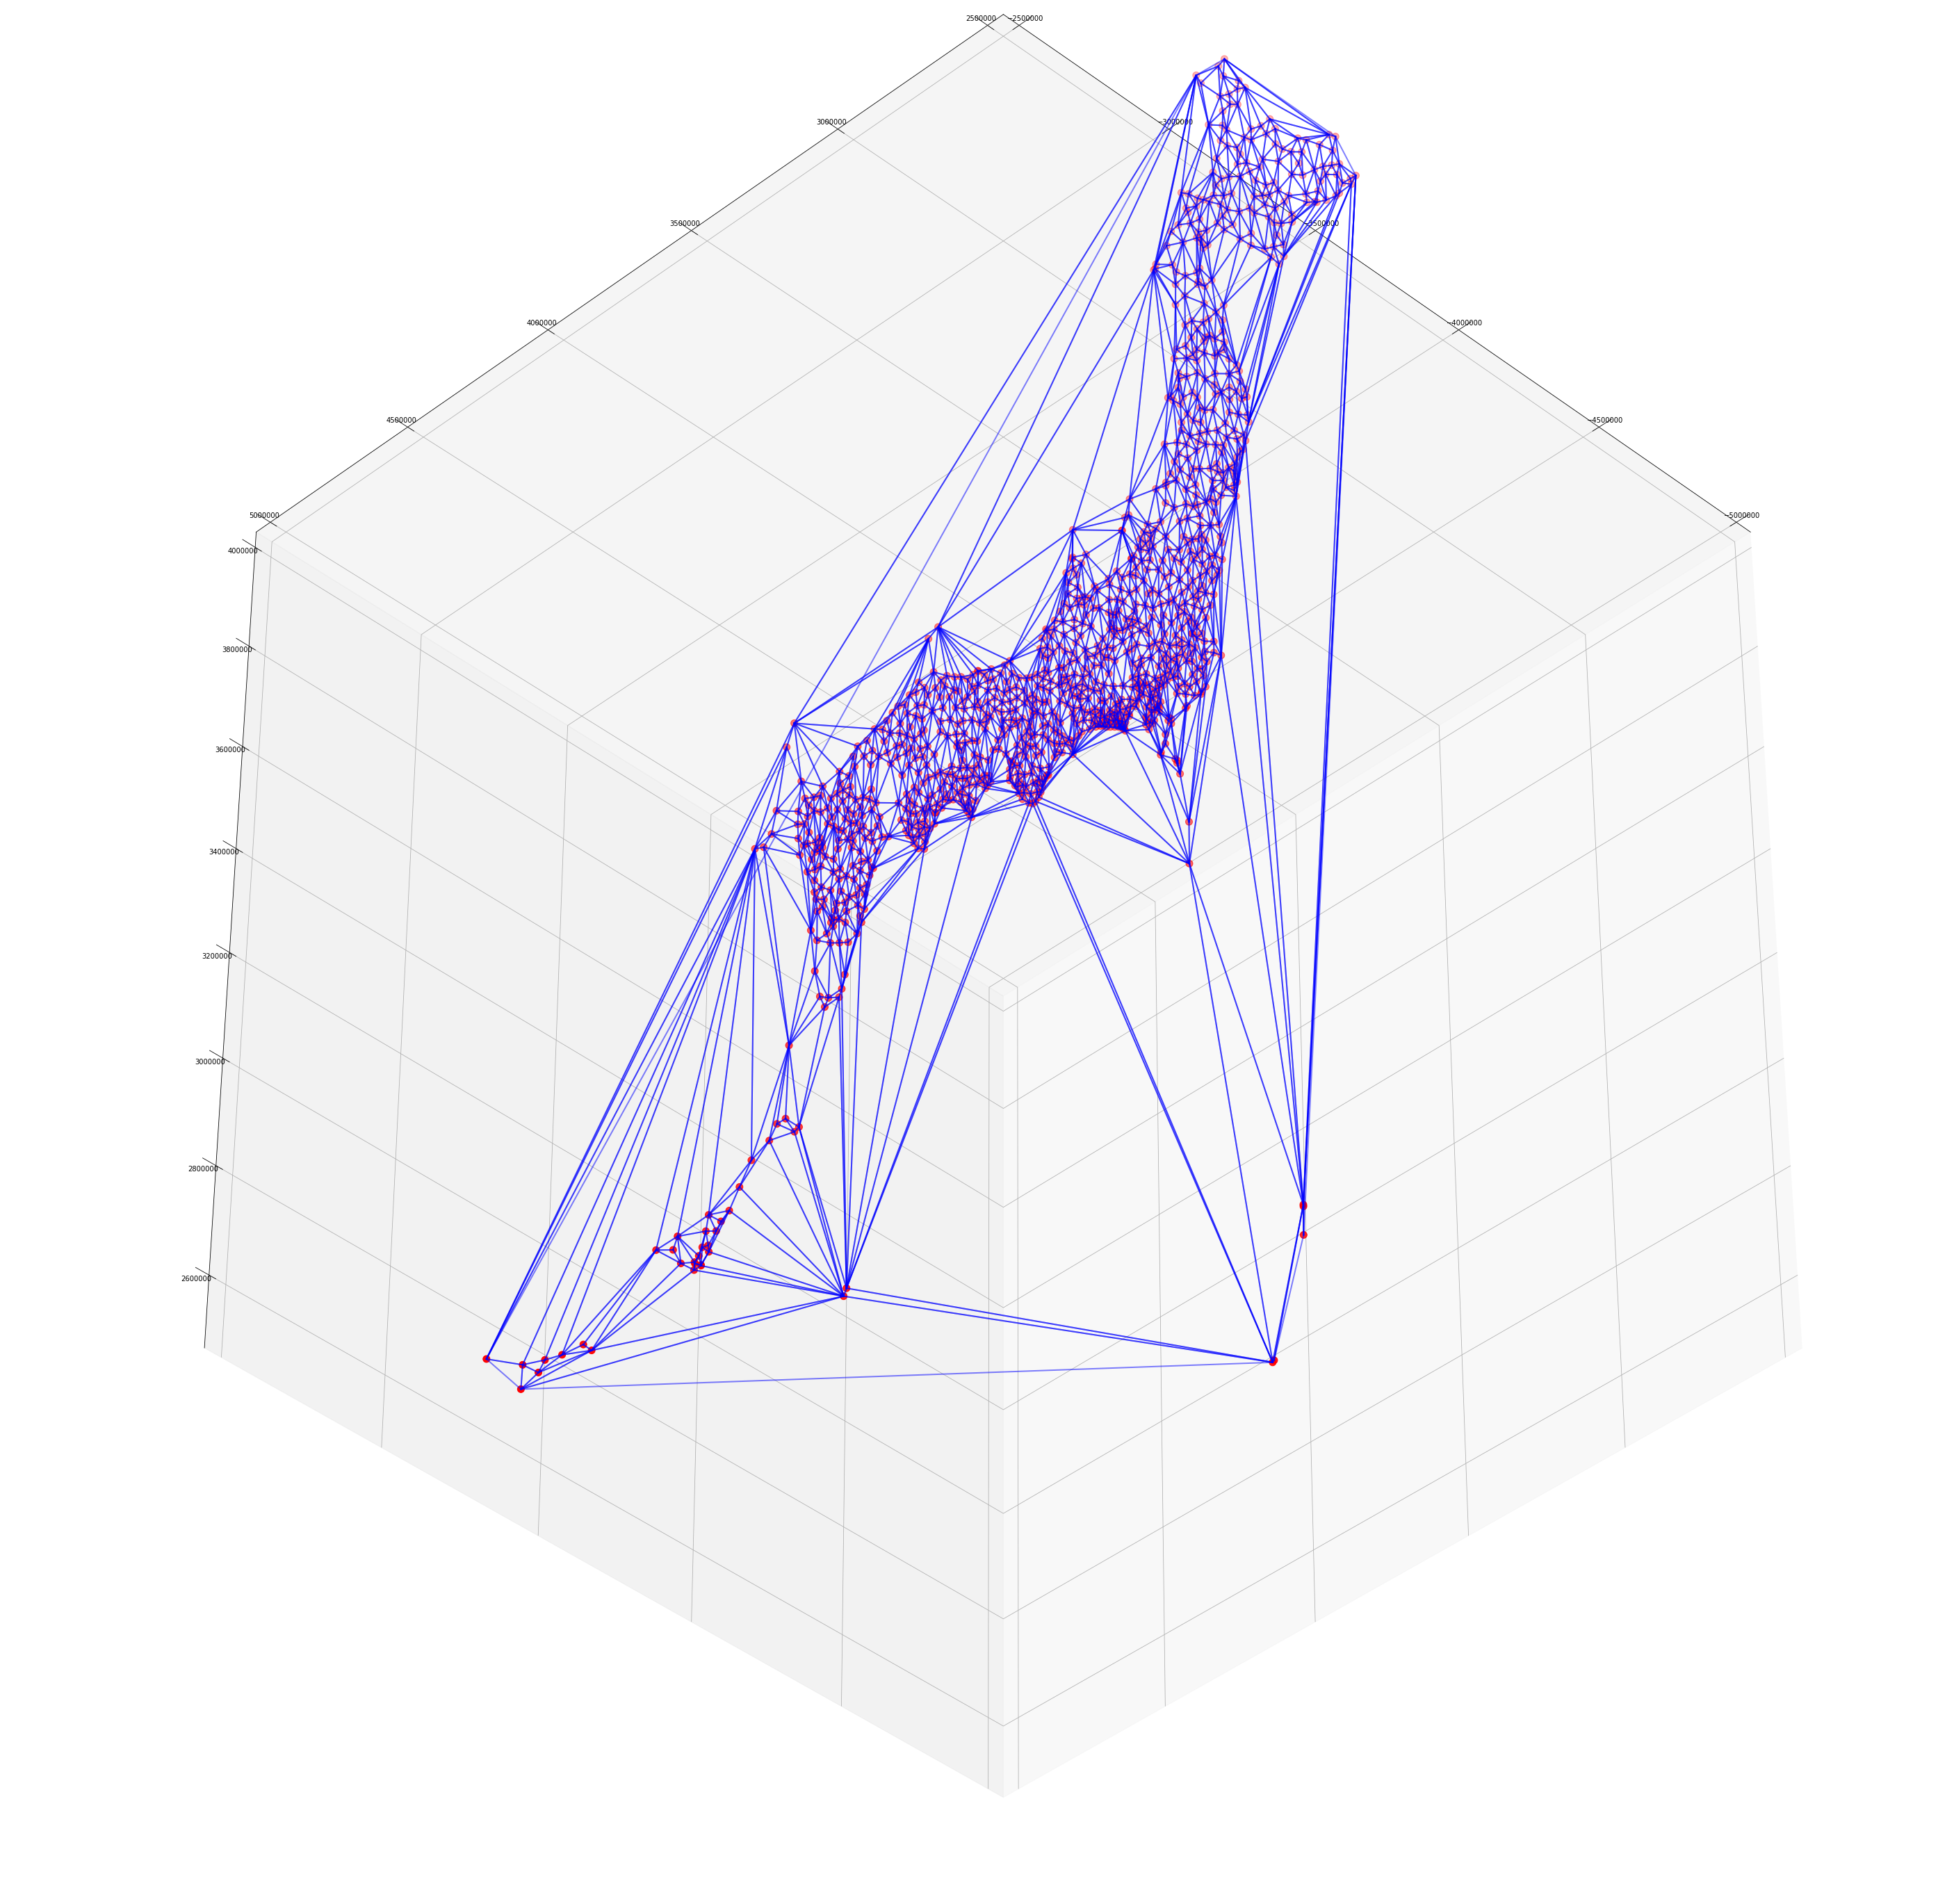

In [164]:
# 記事用の図を作成した際のコード（部分コメントアウトしてあるだけ）

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import axes3d
from sympy.geometry import *

#%matplotlib notebook
%matplotlib inline
plt.style.use({'figure.figsize': (50, 50)})
fig = plt.figure(); ax = plt.axes( projection='3d' )
ax.set_xlim( -2500000,-5000000 )
ax.set_ylim( 2500000, 5000000 )
ax.set_zlim( 2500000, 4000000 )

def plot_tris( ax, points, tri ):
    for tr in tri.simplices: 
        pts = points[ tr, : ]         #pts = [ points[ p ] for p in tr ]
        ax.plot3D( pts[ [0, 1], 0], pts[ [0, 1], 1 ], pts[ [0, 1], 2 ], color=(0,0,1,0.5), lw='2' )
        ax.plot3D( pts[ [0, 2], 0], pts[ [0, 2], 1 ], pts[ [0, 2], 2 ], color=(0,0,1,0.5), lw='2' )
        ax.plot3D( pts[ [1, 2], 0], pts[ [1, 2], 1 ], pts[ [1, 2], 2 ], color=(0,0,1,0.5), lw='2' )
    ax.scatter( points[ :, 0 ], points[ :, 1 ], points[ :, 2 ], color=(1,0,0,1), s=100 )# 電子基準点を描画

def strain_view( ax, xyzs_init, xyzs_last, tri ):
    for tr in tri.simplices:
        area_init = np.linalg.norm( np.outer(   # 初期の三角形面積を外積で計算
              xyzs_ini[ tr[0] ] - xyzs_ini[ tr[1] ],
              xyzs_ini[ tr[2] ] - xyzs_ini[ tr[1] ] ) ) / 2
        area_last = np.linalg.norm( np.outer(  # 最終時期の三角形面積を外積で計算
              xyzs_last[ tr[0] ] - xyzs_last[ tr[1] ],
              xyzs_last[ tr[2] ] - xyzs_last[ tr[1] ] ) ) / 2
        strain = area_last/area_init                 #  面積比として簡易に歪みを算出
        pts = xyzs_init[ tr, : ]                           # ドロネー三角形に属する3点を抽出
        c = ( np.clip( 5000000*abs(strain - 1.0), 0, 1), 0,         # 歪み絶対値大=赤
                np.clip( 1-5000000*abs(strain - 1.0), 0, 1), 0.2 ) # 歪み絶対値少=青
        if area_init < 3000000000: # 巨大な三角領域は描かない
            ax.plot3D( pts[ [0, 1], 0], pts[ [0, 1], 1 ], pts[ [0, 1], 2 ], color=c, lw='10' )
            ax.plot3D( pts[ [1, 2], 0], pts[ [1, 2], 1 ], pts[ [1, 2], 2 ], color=c, lw='10' )
            ax.plot3D( pts[ [2, 0], 0], pts[ [2, 0], 1 ], pts[ [2, 0], 2 ], color=c, lw='10' )
    ax.scatter( xyzs_init[ :, 0 ], xyzs_init[ :, 1 ], xyzs_init[ :, 2 ], color=(0,0,0,1), s=50 )# 電子基準点を描画

# ......... pos データ読み込み .....................
import glob
# 指定ディレクトリ内の各posファイルに対して
posFiles = glob.glob( '/Users/jun/Downloads/gps/2019/*.pos') # 期間分の全サイト
sites = []; days = None
for posFile in posFiles: # 各posファイルを読み、時系列データをリストに格納
    xyzs = []
    file = open( posFile, encoding="utf-8", errors='ignore' )
    lines = file.readlines()
    for line in lines:              # （ヘッダ部除き）データ行のみ読み込む
        words = line.split()
        if len( words ) == 10: # データ行から時系列データ(のXYZを)読み込む
            xyzs.append( list( map( float, words[4:7] ) ) )
    file.close()
    if days is None:             # 最初のsiteの数を基準とする（要確認）
        days = len( xyzs ); sites.append( xyzs )
    else:                              # データロスが無い電子基準点をリストに追加
        if len( xyzs ) == days:
            sites.append( xyzs )       

# 初期位置と最終位置を算出
xyzs_ini = np.array( [ np.array( site[0][0:3] ) for site in sites ] )     # 最初の位置
xyzs_last = np.array( [ np.array( site[-1][0:3] ) for site in sites ] )  # 最後の位置
# 各サイトの地心直交座標系でのxy座標を抽出する
xys = [ site[0][0:2] for site in sites ]
tri = Delaunay( xys ) # ドローネー図を作成し、電子基準点間の最短距離直線（辺）を作成する
plot_tris( ax, xyzs_ini, tri )
#strain_view( ax, xyzs_ini, xyzs_last, tri )

# 移動ベクトルを算出（各サイトの、最初の位置を原点とした、最終位置）
vecXyz = np.array( [ 10000000.0*( xyzs_last[ i ] - xyzs_ini[ i ] ) for i in range( len( sites ) )] ) 
colors = [ np.linalg.norm(v, ord=2)/500000 for v in vecXyz ]
c = [ np.clip( c, 0, 1 )  for c in colors ]
c = [ [ 0, 0, 0, c ] for c in c ]
#ax.quiver( xyzs_ini[ :, 0 ], xyzs_ini[ :, 1 ],  xyzs_ini[ :, 2 ], 
#                vecXyz[ :, 0 ],  vecXyz[ :, 1 ],  vecXyz[ :, 2 ], 
#                color=c, linewidths=2 )

# 地震の発生状況も描画する場合
import csv
reader = csv.reader( open("/Users/jun/Downloads/testdata.csv", "r") )
eqs = np.array( [ [ float(word) for word in line ] for line in reader ] )
#ax.scatter( eqs[ :, 0 ], eqs[ :, 1 ], eqs[ :, 2 ], 
#                 color=( 0, 0.5, 0.2, 0.1), s = 500.0 * eqs[ :, 3 ] )

ax.view_init(elev=-40, azim=-135)

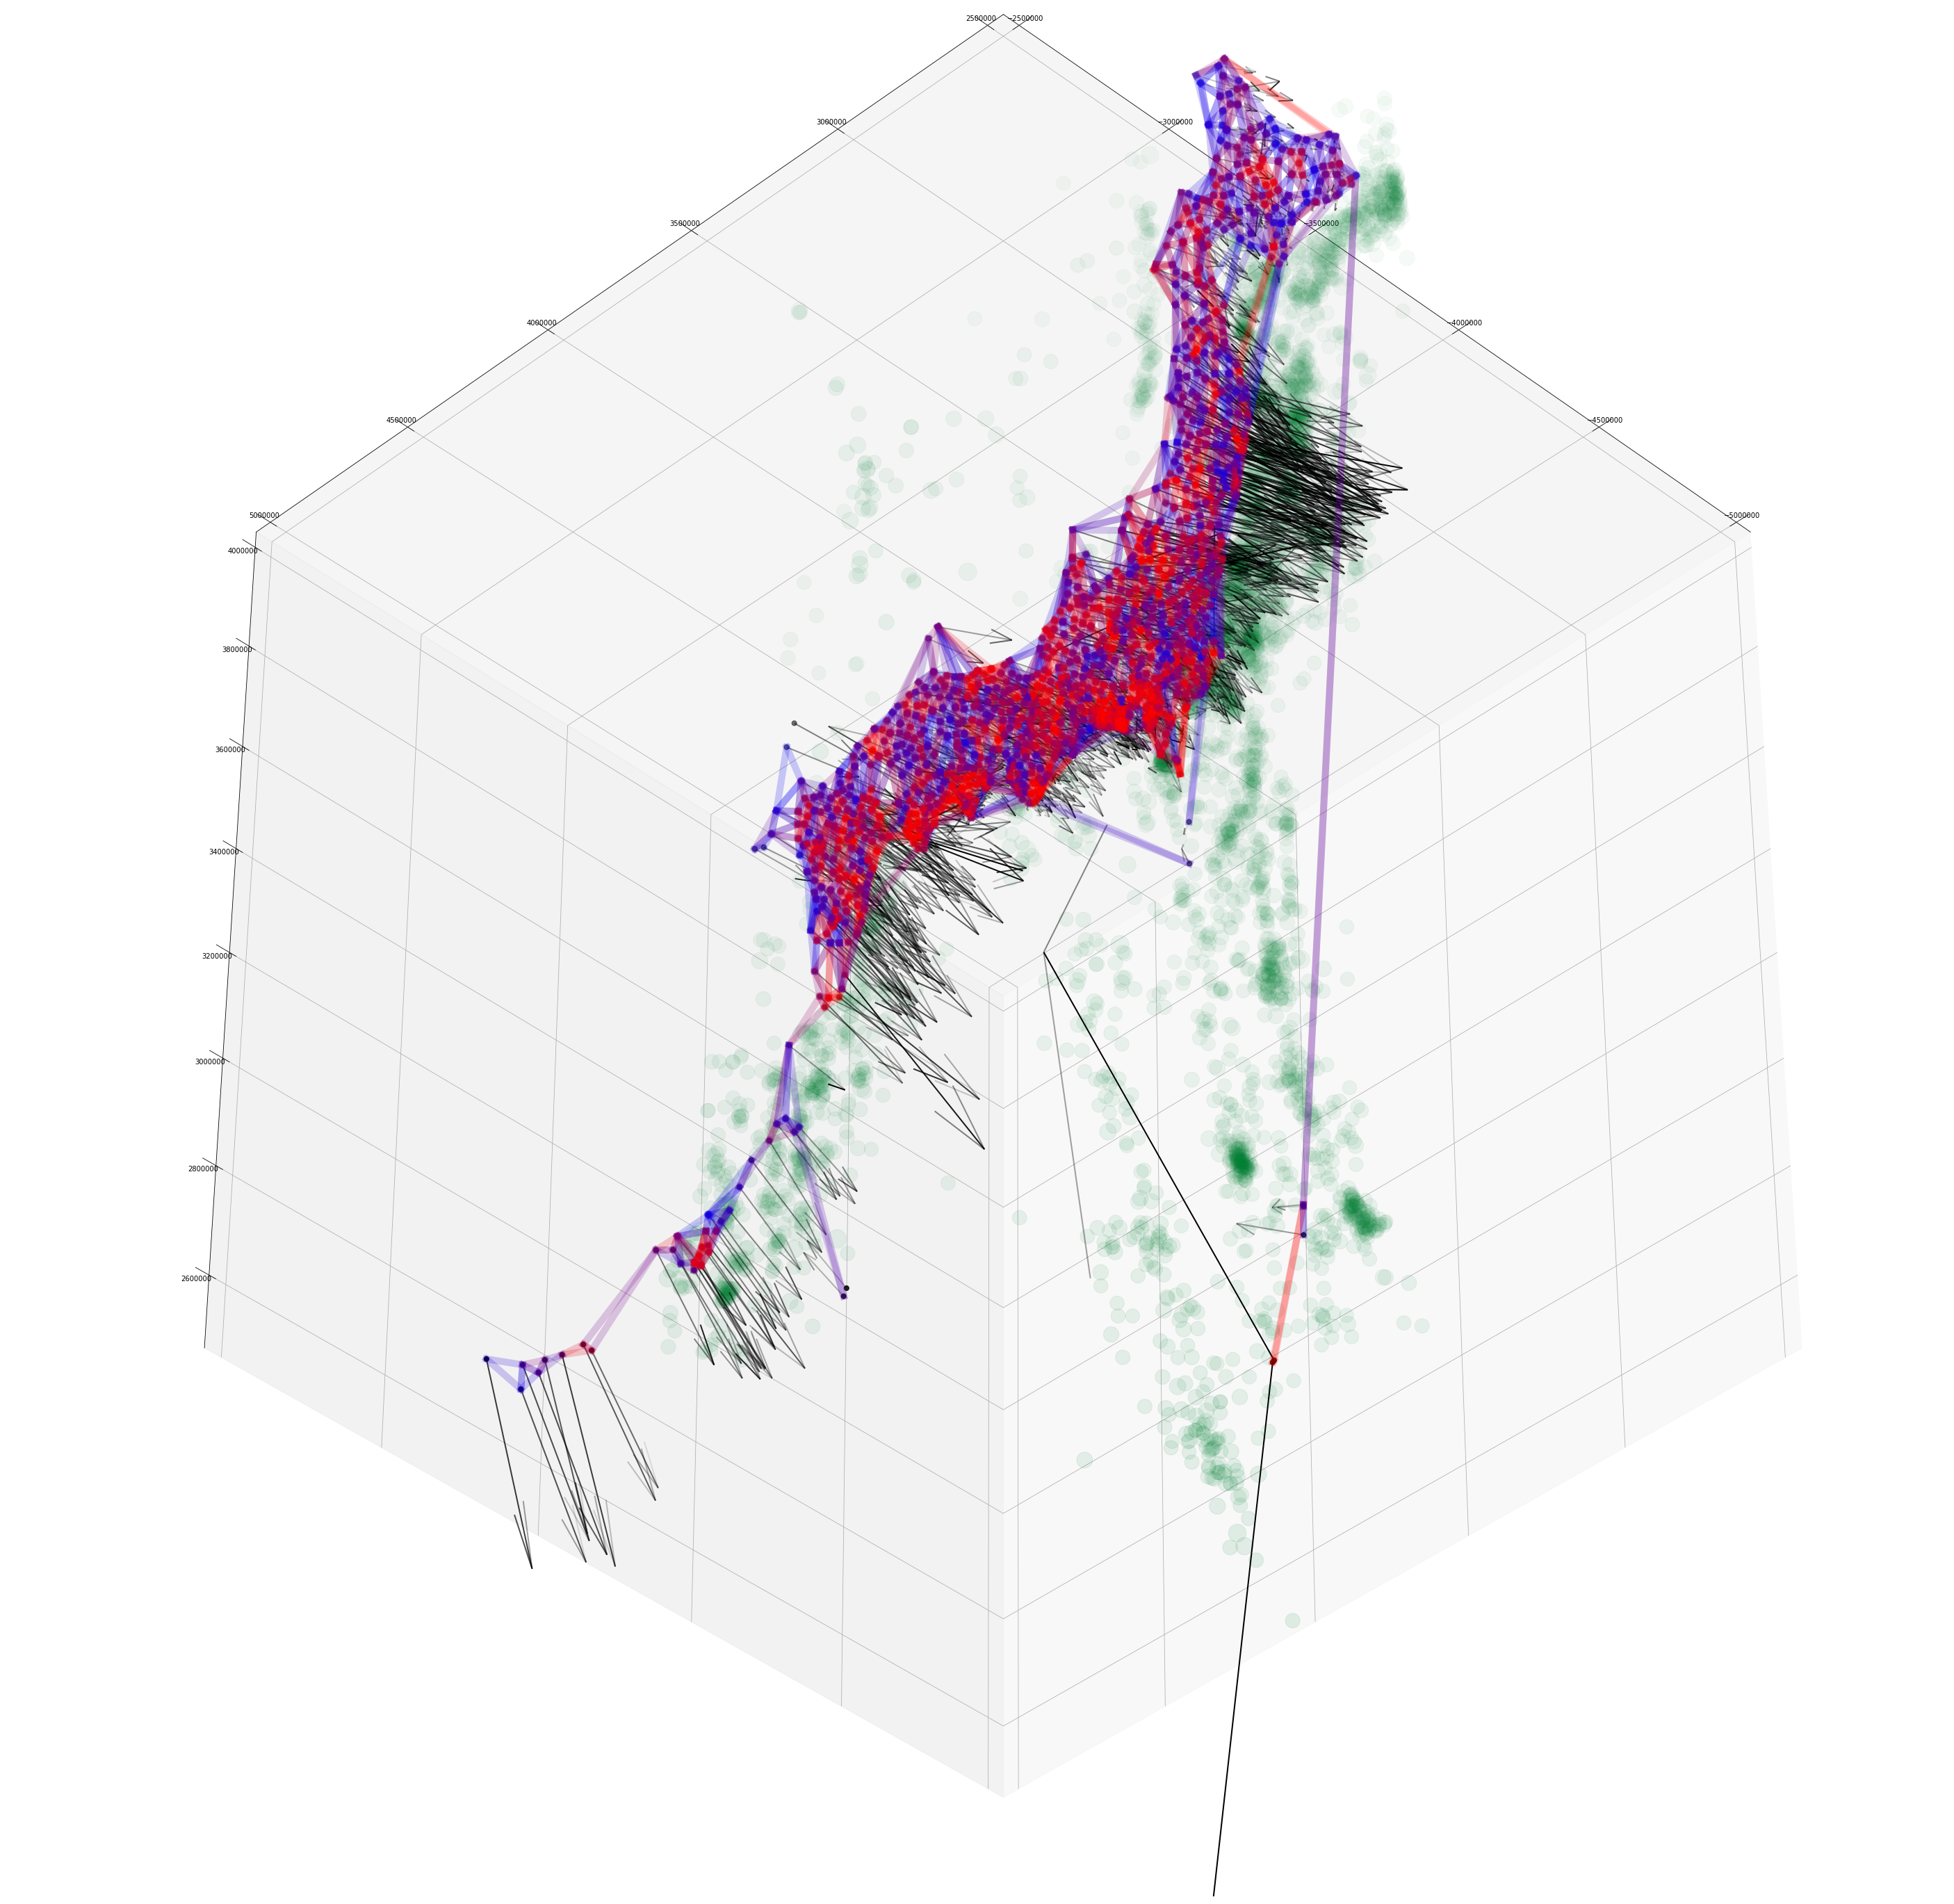

In [166]:
# （コード解説用）

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import axes3d
import glob
import csv

%matplotlib inline

plt.style.use({'figure.figsize': (50, 50)})
fig = plt.figure(); ax = plt.axes( projection='3d' )
ax.set_xlim( -2500000,-5000000 )
ax.set_ylim( 2500000, 5000000 )
ax.set_zlim( 2500000, 4000000 )

# 指定ディレクトリ内の各基準点の位置推移を（posファイルから）読み込む
posFiles = glob.glob( '/Users/jun/Downloads/gps/2019/*.pos') # 期間分の基準点
sites = []; days = None   # 各基準点の位置推移をリスト sites に読み込む
for posFile in posFiles:   # 各基準点の位置（pos）ファイルをそれぞれ読む
    file = open( posFile, encoding="utf-8", errors='ignore' )
    lines = file.readlines(); xyzs = []  # 各基準点位置をリスト（xyzs）に格納する
    for line in lines:              # 各行を読み
        words = line.split()
        if len( words ) == 10: # データ行は10列→読み込む
            xyzs.append( list( map( float, words[4:7] ) ) ) # 地心直交座標系のXYZ位置
    file.close()                        # 読み込み終了し、ファイルを閉じる
    if days is None:              # 一番最初の基準点は自動登録
        days = len( xyzs ); sites.append( xyzs )
    else:                               # データロスが無い電子基準点をリストに追加
        if len( xyzs ) == days:  # 最初のsiteの数を基準とする
            sites.append( xyzs )       

# 初期XYZ位置と最終XYZ位置を算出
xyzs_ini = np.array( [ np.array( site[0][0:3] ) for site in sites ] )     # 最初の位置
xyzs_last = np.array( [ np.array( site[-1][0:3] ) for site in sites ] )  # 最後の位置

# 移動ベクトルを算出（各基準点のー最初の位置を原点としたー最終位置）
vecXyz = np.array( [ 10000000.0*( xyzs_last[ i ]-xyzs_ini[ i ] ) for i in range( len( sites ) )] ) 
colors = [ np.linalg.norm( v, ord=2 )/500000 for v in vecXyz ]  # 距離にする
c = [ np.clip( c, 0, 1 )  for c in colors ]
c = [ [ 0, 0, 0, c ] for c in c ]
ax.quiver( xyzs_ini[ :, 0 ], xyzs_ini[ :, 1 ],  xyzs_ini[ :, 2 ], # 3次元ベクトルとして表示
                vecXyz[ :, 0 ],  vecXyz[ :, 1 ],  vecXyz[ :, 2 ], color=c, linewidths=2 )

# XY座標のみ使いドロネー分割する
xys = [ site[0][0:2] for site in sites ]   # 各基準点の地心直交座標系でのxy座標を抽出
tri = Delaunay( xys ) # ドロネー図を作成し、基準点間直線（辺）を作成する

def strain_view( ax, xyzs_init, xyzs_last, tri ):
    for tr in tri.simplices:
        area_init = np.linalg.norm( np.outer(   # 初期の三角形面積を外積で計算
              xyzs_ini[ tr[0] ] - xyzs_ini[ tr[1] ],
              xyzs_ini[ tr[2] ] - xyzs_ini[ tr[1] ] ) ) / 2
        area_last = np.linalg.norm( np.outer(  # 最終時期の三角形面積を外積で計算
              xyzs_last[ tr[0] ] - xyzs_last[ tr[1] ],
              xyzs_last[ tr[2] ] - xyzs_last[ tr[1] ] ) ) / 2
        strain = area_last/area_init                 #  簡易的に、面積比として歪みを算出
        pts = xyzs_init[ tr, : ]                           # ドロネー三角形に属する3点を抽出
        c = ( np.clip( 5000000*abs(strain - 1.0), 0, 1), 0,         # 歪み絶対値大=赤
                np.clip( 1-5000000*abs(strain - 1.0), 0, 1), 0.2 ) # 歪み絶対値少=青
        if area_init < 3000000000: # 巨大な三角領域は描かない
            ax.plot3D( pts[ [0, 1], 0], pts[ [0, 1], 1 ], pts[ [0, 1], 2 ], color=c, lw='10' )
            ax.plot3D( pts[ [1, 2], 0], pts[ [1, 2], 1 ], pts[ [1, 2], 2 ], color=c, lw='10' )
            ax.plot3D( pts[ [2, 0], 0], pts[ [2, 0], 1 ], pts[ [2, 0], 2 ], color=c, lw='10' )
    ax.scatter( xyzs_init[ :, 0 ], xyzs_init[ :, 1 ], xyzs_init[ :, 2 ], # 各基準点を描画 
                     color=(0,0,0,1), s=50 )

# ドロネー分割領域を歪みとともに表示
strain_view( ax, xyzs_ini, xyzs_last, tri ) 

# 地震の発生状況も重ねて描画する
reader = csv.reader( open("/Users/jun/Downloads/eq.csv", "r") )
eqs = np.array( [ [ float(word) for word in line ] for line in reader ] )
ax.scatter( eqs[ :, 0 ], eqs[ :, 1 ], eqs[ :, 2 ], color=( 0, 0.5, 0.2, 0.1), s=500.0 * eqs[ :, 3 ] )

ax.view_init(elev=-40, azim=-135) # 3次元的なデータ群を、日本列島上空から眺める